# GoEmotions: Fine-Grained Emotion Classification

28-class multi-label emotion classification on Reddit comments. We'll go from a bag-of-words baseline through BiLSTM with GloVe embeddings to fine-tuned RoBERTa.

### Running on Google Colab

In [5]:
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    import torch
    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name(0)}")
        print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    else:
        print("No GPU detected. Go to Runtime > Change runtime type > T4 GPU")

    # uncomment if you want to save stuff to Drive
    # from google.colab import drive
    # drive.mount('/content/drive')
else:
    print("Not running on Colab, skipping setup.")

GPU: Tesla T4
Memory: 15.6 GB


In [6]:
!pip install -q datasets transformers

from datasets import load_dataset
import pandas as pd
import numpy as np

np.random.seed(42)

In [7]:
raw = load_dataset("google-research-datasets/go_emotions", "simplified")

emotions = [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
    'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
    'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
    'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization',
    'relief', 'remorse', 'sadness', 'surprise', 'neutral'
]

def to_dataframe(split):
    df = pd.DataFrame(split)
    label_matrix = np.zeros((len(df), len(emotions)), dtype=int)
    for i, label_ids in enumerate(df['labels']):
        for lid in label_ids:
            label_matrix[i, lid] = 1
    for j, emo in enumerate(emotions):
        df[emo] = label_matrix[:, j]
    df = df.drop(columns=['labels', 'id'])
    return df

train_df = to_dataframe(raw['train'])
val_df = to_dataframe(raw['validation'])
test_df = to_dataframe(raw['test'])

print(f'Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

simplified/train-00000-of-00001.parquet:   0%|          | 0.00/2.77M [00:00<?, ?B/s]

simplified/validation-00000-of-00001.par(…):   0%|          | 0.00/350k [00:00<?, ?B/s]

simplified/test-00000-of-00001.parquet:   0%|          | 0.00/347k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

Train: 43410, Val: 5426, Test: 5427


In [8]:
y_train = train_df[emotions].values
y_val = val_df[emotions].values
y_test = test_df[emotions].values

print(f'Label shape: {y_train.shape}')

Label shape: (43410, 28)


## Dataset Exploration

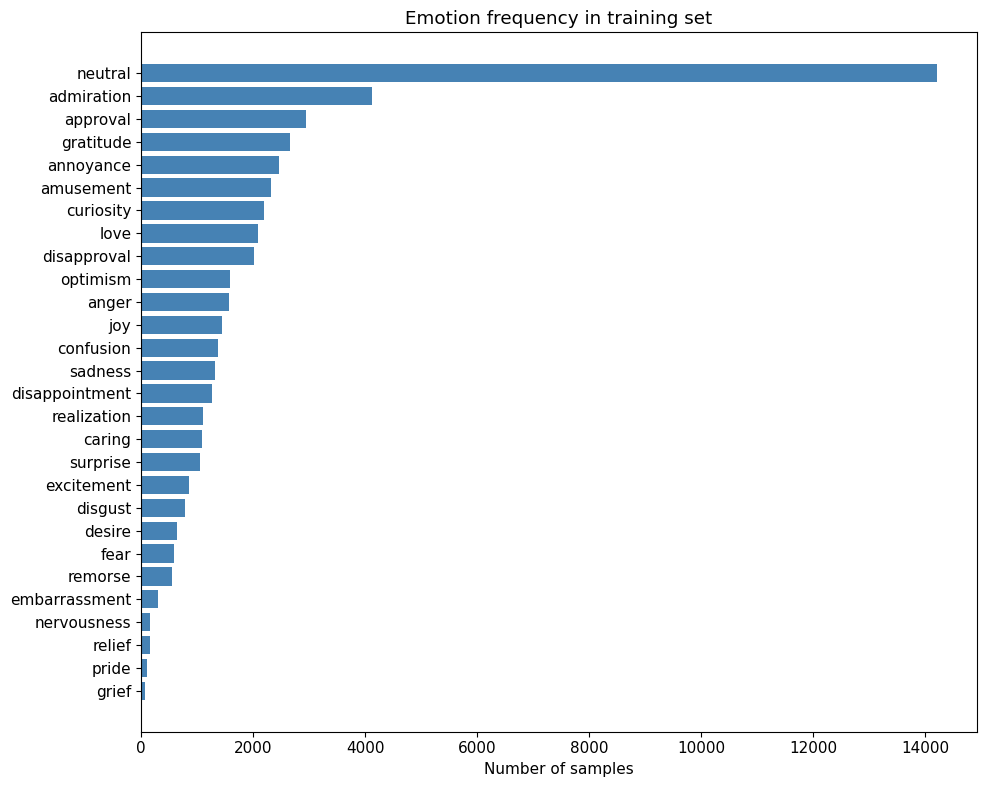

In [9]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['font.size'] = 11

counts = train_df[emotions].sum().sort_values()
plt.barh(counts.index, counts.values, color='steelblue')
plt.xlabel('Number of samples')
plt.title('Emotion frequency in training set')
plt.tight_layout()
plt.show()

Neutral dominates with ~18k samples, followed by admiration and annoyance in the 3-4k range. At the bottom, grief has around 100 training samples. That's roughly a 180x gap between the most and least common emotions.

In [10]:
# some interesting examples: multi-label, rare emotions, ambiguous
multi_label = train_df[train_df[emotions].sum(axis=1) >= 2].head(3)
for _, row in multi_label.iterrows():
    labels = [e for e in emotions if row[e] == 1]
    print(f"'{row['text']}'")
    print(f'  -> {labels}\n')

# a grief example
grief_rows = train_df[train_df['grief'] == 1].head(1)
for _, row in grief_rows.iterrows():
    labels = [e for e in emotions if row[e] == 1]
    print(f"'{row['text']}'")
    print(f'  -> {labels}\n')

# contradictory labels
ambiguous = train_df[(train_df['amusement'] == 1) & (train_df['annoyance'] == 1)].head(1)
if len(ambiguous) == 0:
    ambiguous = train_df[(train_df['approval'] == 1) & (train_df['disapproval'] == 1)].head(1)
for _, row in ambiguous.iterrows():
    labels = [e for e in emotions if row[e] == 1]
    print(f"'{row['text']}'")
    print(f'  -> {labels}\n')

'We need more boards and to create a bit more space for [NAME]. Then we’ll be good.'
  -> ['desire', 'optimism']

'Aww... she'll probably come around eventually, I'm sure she was just jealous of [NAME]... I mean, what woman wouldn't be! lol '
  -> ['amusement', 'approval']

'Shit, I guess I accidentally bought a Pay-Per-View boxing match'
  -> ['annoyance', 'embarrassment']

'I miss them being alive'
  -> ['grief', 'sadness']

'> I really hope QCX addresses that last point. Who knows [NAME] could've fled with the money or something. What the hell dude. lol'
  -> ['amusement', 'annoyance', 'desire']



In [11]:
label_counts = train_df[emotions].sum(axis=1)
print(f'Single-label samples: {(label_counts == 1).sum()} ({(label_counts == 1).mean():.1%})')
print(f'Multi-label samples:  {(label_counts >= 2).sum()} ({(label_counts >= 2).mean():.1%})')
print(f'Average labels per sample: {label_counts.mean():.2f}')

Single-label samples: 36308 (83.6%)
Multi-label samples:  7102 (16.4%)
Average labels per sample: 1.18


Most samples have exactly one label, but ~15-20% have two or more. That makes this a genuine multi-label problem, not just multi-class.

### Majority-Class Baseline

In [12]:
from sklearn.metrics import f1_score

most_common = train_df[emotions].sum().idxmax()
print(f'Most common emotion: {most_common}')

# predict only the most common emotion for every sample
y_majority = np.zeros_like(y_test)
y_majority[:, emotions.index(most_common)] = 1

majority_f1 = f1_score(y_test, y_majority, average='macro', zero_division=0)
print(f'Majority-class Macro F1: {majority_f1:.4f}')

Most common emotion: neutral
Majority-class Macro F1: 0.0177


Macro F1 of 0.02. Predicting "neutral" for everything scores zero on 27 out of 28 emotions, and macro F1 weights them all equally. This is the floor we're working from.

## TF-IDF + Logistic Regression

Bag-of-words baseline with balanced class weights since the dataset's pretty skewed towards neutral and admiration.

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), stop_words='english')
X_train_tfidf = tfidf.fit_transform(train_df['text'])
X_test_tfidf = tfidf.transform(test_df['text'])

In [14]:
from sklearn.metrics import classification_report

clf = OneVsRestClassifier(
    LogisticRegression(solver='liblinear', class_weight='balanced', max_iter=1000)
)
clf.fit(X_train_tfidf, y_train)
y_pred_tfidf = clf.predict(X_test_tfidf)

tfidf_f1 = f1_score(y_test, y_pred_tfidf, average='macro', zero_division=0)
print(f'TF-IDF Macro F1: {tfidf_f1:.4f}')

TF-IDF Macro F1: 0.3751


In [15]:
print(classification_report(y_test, y_pred_tfidf, target_names=emotions, zero_division=0))

                precision    recall  f1-score   support

    admiration       0.47      0.75      0.58       504
     amusement       0.69      0.91      0.78       264
         anger       0.26      0.64      0.37       198
     annoyance       0.19      0.54      0.28       320
      approval       0.16      0.50      0.24       351
        caring       0.14      0.51      0.22       135
     confusion       0.13      0.52      0.21       153
     curiosity       0.13      0.41      0.20       284
        desire       0.21      0.57      0.31        83
disappointment       0.12      0.48      0.19       151
   disapproval       0.14      0.47      0.21       267
       disgust       0.28      0.65      0.39       123
 embarrassment       0.17      0.41      0.24        37
    excitement       0.15      0.59      0.24       103
          fear       0.42      0.74      0.53        78
     gratitude       0.82      0.92      0.87       352
         grief       0.19      1.00      0.32  

~0.38 Macro F1. Gratitude and amusement do well since they have obvious keyword signals ("thanks", "lol"). Grief actually hits 0.32 F1 here (only 6 test samples, but it found them all). Relief is the one that's genuinely near zero.

## BiLSTM + GloVe 300d

Embeddings let the model know that "happy" and "joyful" are related without needing them in the same training examples. GloVe 300d gives us 300-dimensional vectors pretrained on 6 billion tokens.

In [16]:
import os

if not os.path.exists('glove.6B.300d.txt'):
    print('Downloading GloVe (takes a minute)...')
    !wget -q http://nlp.stanford.edu/data/glove.6B.zip
    !unzip -q glove.6B.zip glove.6B.300d.txt
    !rm -f glove.6B.zip glove.6B.50d.txt glove.6B.100d.txt glove.6B.200d.txt
    print('Done.')
else:
    print('GloVe already downloaded.')

Done.


In [17]:
import torch
torch.manual_seed(42)
import torch.nn as nn
from collections import Counter

# load glove vectors
glove = {}
with open('glove.6B.300d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        glove[values[0]] = np.asarray(values[1:], dtype='float32')
print(f'GloVe loaded: {len(glove)} words')

def build_vocab(texts, min_freq=2):
    counter = Counter()
    for text in texts:
        counter.update(text.lower().split())
    vocab = {'<PAD>': 0, '<UNK>': 1}
    for word, count in counter.items():
        if count >= min_freq:
            vocab[word] = len(vocab)
    return vocab

vocab = build_vocab(train_df['text'].tolist())
print(f'Vocab size: {len(vocab)}')

# embedding matrix: random normal for OOV, zeros for PAD
embed_dim = 300
embedding_matrix = np.random.normal(scale=0.6, size=(len(vocab), embed_dim)).astype('float32')
embedding_matrix[0] = 0  # PAD

found = 0
for word, idx in vocab.items():
    if word in glove:
        embedding_matrix[idx] = glove[word]
        found += 1

print(f'GloVe coverage: {found}/{len(vocab)} ({found/len(vocab):.1%})')

del glove  # free memory

GloVe loaded: 400000 words
Vocab size: 18607
GloVe coverage: 10963/18607 (58.9%)


In [18]:
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

class EmotionDataset(Dataset):
    def __init__(self, df, vocab):
        self.texts = df['text'].tolist()
        self.labels = df[emotions].values
        self.vocab = vocab

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        words = self.texts[idx].lower().split()
        indices = [self.vocab.get(w, 1) for w in words]  # 1 = UNK
        return torch.tensor(indices, dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.float)

def collate_fn(batch):
    seqs, labels = zip(*batch)
    padded = pad_sequence(seqs, batch_first=True, padding_value=0)
    return padded, torch.stack(labels)

train_loader = DataLoader(EmotionDataset(train_df, vocab), batch_size=64, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(EmotionDataset(val_df, vocab), batch_size=128, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(EmotionDataset(test_df, vocab), batch_size=128, shuffle=False, collate_fn=collate_fn)

In [19]:
class BiLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_labels, pretrained_embeddings):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(pretrained_embeddings))
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim * 2, num_labels)

    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.lstm(embedded)
        # concat forward and backward hidden states
        out = torch.cat((hidden[-2], hidden[-1]), dim=1)
        out = self.dropout(out)
        return self.fc(out)

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using: {device}')

model_lstm = BiLSTM(
    vocab_size=len(vocab),
    embed_dim=embed_dim,
    hidden_dim=128,
    num_labels=28,
    pretrained_embeddings=embedding_matrix
).to(device)

# no pos_weight: the aggressive weighting in the old version was hurting more than helping
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=0.001)

for epoch in range(10):
    model_lstm.train()
    total_loss = 0
    for texts, labels in train_loader:
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model_lstm(texts)
        loss = criterion(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_lstm.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()

    # val macro f1 each epoch
    model_lstm.eval()
    val_probs, val_true = [], []
    with torch.no_grad():
        for texts, labels in val_loader:
            texts = texts.to(device)
            logits = model_lstm(texts)
            val_probs.append(torch.sigmoid(logits).cpu().numpy())
            val_true.append(labels.numpy())
    val_probs = np.vstack(val_probs)
    val_true = np.vstack(val_true)
    val_preds = (val_probs > 0.5).astype(int)
    val_f1 = f1_score(val_true, val_preds, average='macro', zero_division=0)

    print(f'Epoch {epoch+1}/10 | Loss: {total_loss/len(train_loader):.4f} | Val F1: {val_f1:.4f}')

Using: cuda
Epoch 1/10 | Loss: 0.1483 | Val F1: 0.0865
Epoch 2/10 | Loss: 0.1165 | Val F1: 0.1468
Epoch 3/10 | Loss: 0.1026 | Val F1: 0.1969
Epoch 4/10 | Loss: 0.0922 | Val F1: 0.2309
Epoch 5/10 | Loss: 0.0828 | Val F1: 0.2700
Epoch 6/10 | Loss: 0.0741 | Val F1: 0.2854
Epoch 7/10 | Loss: 0.0662 | Val F1: 0.3079
Epoch 8/10 | Loss: 0.0588 | Val F1: 0.3183
Epoch 9/10 | Loss: 0.0527 | Val F1: 0.3325
Epoch 10/10 | Loss: 0.0471 | Val F1: 0.3310


### Threshold Tuning

Default 0.5 threshold isn't great for imbalanced classes. A rare emotion might only get 0.3 confidence, which could still be worth predicting. We'll sweep per class on the val set.

In [21]:
def find_best_thresholds(probs, true_labels, label_names, low=0.2, high=0.6, step=0.05):
    """Sweep thresholds per class on val set."""
    thresholds = {}
    for i, name in enumerate(label_names):
        best_f1, best_t = 0, 0.5
        for t in np.arange(low, high + step, step):
            preds = (probs[:, i] >= t).astype(int)
            score = f1_score(true_labels[:, i], preds, average='binary', zero_division=0)
            if score > best_f1:
                best_f1 = score
                best_t = round(t, 2)
        thresholds[name] = best_t
    return thresholds

def apply_thresholds(probs, thresholds, label_names):
    preds = np.zeros_like(probs, dtype=int)
    for i, name in enumerate(label_names):
        preds[:, i] = (probs[:, i] >= thresholds[name]).astype(int)
    return preds

# get fresh val predictions
model_lstm.eval()
val_probs_all, val_labels_all = [], []
with torch.no_grad():
    for texts, labels in val_loader:
        texts = texts.to(device)
        val_probs_all.append(torch.sigmoid(model_lstm(texts)).cpu().numpy())
        val_labels_all.append(labels.numpy())
val_probs_all = np.vstack(val_probs_all)
val_labels_all = np.vstack(val_labels_all)

lstm_thresholds = find_best_thresholds(val_probs_all, val_labels_all, emotions)
print('Optimized thresholds (sample):')
for name in list(lstm_thresholds.keys())[:5]:
    print(f'  {name}: {lstm_thresholds[name]}')

Optimized thresholds (sample):
  admiration: 0.35
  amusement: 0.2
  anger: 0.5
  annoyance: 0.2
  approval: 0.2


In [22]:
# test set evaluation
model_lstm.eval()
test_probs_lstm = []
with torch.no_grad():
    for texts, labels in test_loader:
        texts = texts.to(device)
        test_probs_lstm.append(torch.sigmoid(model_lstm(texts)).cpu().numpy())
test_probs_lstm = np.vstack(test_probs_lstm)

y_pred_lstm = apply_thresholds(test_probs_lstm, lstm_thresholds, emotions)
lstm_f1 = f1_score(y_test, y_pred_lstm, average='macro', zero_division=0)
print(f'BiLSTM Macro F1 (optimized thresholds): {lstm_f1:.4f}')

BiLSTM Macro F1 (optimized thresholds): 0.3714


In [23]:
print(classification_report(y_test, y_pred_lstm, target_names=emotions, zero_division=0))

                precision    recall  f1-score   support

    admiration       0.56      0.57      0.56       504
     amusement       0.66      0.71      0.69       264
         anger       0.46      0.26      0.33       198
     annoyance       0.25      0.32      0.28       320
      approval       0.25      0.28      0.26       351
        caring       0.22      0.26      0.24       135
     confusion       0.28      0.33      0.31       153
     curiosity       0.36      0.43      0.39       284
        desire       0.61      0.34      0.43        83
disappointment       0.30      0.17      0.21       151
   disapproval       0.29      0.25      0.27       267
       disgust       0.37      0.29      0.33       123
 embarrassment       0.39      0.19      0.25        37
    excitement       0.39      0.20      0.27       103
          fear       0.69      0.53      0.60        78
     gratitude       0.93      0.85      0.89       352
         grief       0.00      0.00      0.00  

BiLSTM got 0.37, essentially matching TF-IDF's 0.38. With only 58.9% GloVe coverage, 41% of the vocab had no pretrained vector at all. GloVe was trained on Wikipedia, not Reddit, so words like "lmao" and "tbh" get random embeddings that don't help.

## RoBERTa Fine-Tuning

RoBERTa reads the whole sentence at once through self-attention, so it can connect "not" to "happy" across a sentence. It's also pretrained on 160GB of text, which helps with rare emotions.

In [24]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from torch.utils.data import Dataset as TorchDataset

tokenizer = AutoTokenizer.from_pretrained('roberta-base')

# sqrt-dampened pos_weights: helps with imbalance without exploding gradients
pos_counts = y_train.sum(axis=0)
neg_counts = y_train.shape[0] - pos_counts
pos_weights_roberta = np.sqrt(neg_counts / (pos_counts + 1e-5))
pos_weights_tensor = torch.tensor(pos_weights_roberta, dtype=torch.float)

class GoEmotionsDataset(TorchDataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(texts, padding='max_length', truncation=True, max_length=128)
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

    def __len__(self):
        return len(self.labels)

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [25]:
train_dataset = GoEmotionsDataset(train_df['text'].tolist(), y_train)
val_dataset = GoEmotionsDataset(val_df['text'].tolist(), y_val)
test_dataset = GoEmotionsDataset(test_df['text'].tolist(), y_test)
print(f'Tokenized. Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}')

Tokenized. Train: 43410, Val: 5426, Test: 5427


In [26]:
model_roberta = AutoModelForSequenceClassification.from_pretrained(
    'roberta-base', num_labels=28, problem_type='multi_label_classification'
)

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop('labels')
        outputs = model(**inputs)
        logits = outputs.get('logits')
        loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weights_tensor.to(logits.device))
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss

training_args = TrainingArguments(
    output_dir='./results_roberta',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    learning_rate=2e-5,
    warmup_steps=500,
    weight_decay=0.01,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    logging_steps=200,
)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: roberta-base
Key                             | Status     | 
--------------------------------+------------+-
lm_head.dense.weight            | UNEXPECTED | 
lm_head.dense.bias              | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
classifier.dense.weight         | MISSING    | 
classifier.dense.bias           | MISSING    | 
classifier.out_proj.bias        | MISSING    | 
classifier.out_proj.weight      | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


In [27]:
trainer = WeightedTrainer(
    model=model_roberta,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.252725,0.234707
2,0.213087,0.216088
3,0.180888,0.212317


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['roberta.embeddings.LayerNorm.weight', 'roberta.embeddings.LayerNorm.bias', 'roberta.encoder.layer.0.attention.output.LayerNorm.weight', 'roberta.encoder.layer.0.attention.output.LayerNorm.bias', 'roberta.encoder.layer.0.output.LayerNorm.weight', 'roberta.encoder.layer.0.output.LayerNorm.bias', 'roberta.encoder.layer.1.attention.output.LayerNorm.weight', 'roberta.encoder.layer.1.attention.output.LayerNorm.bias', 'roberta.encoder.layer.1.output.LayerNorm.weight', 'roberta.encoder.layer.1.output.LayerNorm.bias', 'roberta.encoder.layer.2.attention.output.LayerNorm.weight', 'roberta.encoder.layer.2.attention.output.LayerNorm.bias', 'roberta.encoder.layer.2.output.LayerNorm.weight', 'roberta.encoder.layer.2.output.LayerNorm.bias', 'roberta.encoder.layer.3.attention.output.LayerNorm.weight', 'roberta.encoder.layer.3.attention.output.LayerNorm.bias', 'roberta.encoder.layer.3.output.LayerNorm.weight', 'roberta.encoder.layer.3.output.Laye

TrainOutput(global_step=8142, training_loss=0.24159450010947647, metrics={'train_runtime': 3132.7139, 'train_samples_per_second': 41.571, 'train_steps_per_second': 2.599, 'total_flos': 8568237917583360.0, 'train_loss': 0.24159450010947647, 'epoch': 3.0})

### Per-Class Threshold Optimization

Same idea as the LSTM: sweep thresholds on the validation set, pick the best per emotion.

In [28]:
# val predictions -> sigmoid -> threshold optimization
raw_preds = trainer.predict(val_dataset).predictions
val_probs_roberta = 1 / (1 + np.exp(-raw_preds))  # sigmoid

roberta_thresholds = find_best_thresholds(val_probs_roberta, y_val, emotions, low=0.1, high=0.6)
print('Optimized thresholds (sample):')
for name in list(roberta_thresholds.keys())[:5]:
    print(f'  {name}: {roberta_thresholds[name]}')

Optimized thresholds (sample):
  admiration: 0.6
  amusement: 0.6
  anger: 0.55
  annoyance: 0.5
  approval: 0.5


In [29]:
test_raw = trainer.predict(test_dataset).predictions
test_probs_roberta = 1 / (1 + np.exp(-test_raw))

y_pred_roberta = apply_thresholds(test_probs_roberta, roberta_thresholds, emotions)
roberta_f1 = f1_score(y_test, y_pred_roberta, average='macro', zero_division=0)
print(f'RoBERTa Macro F1: {roberta_f1:.4f}')

RoBERTa Macro F1: 0.5296


In [30]:
print(classification_report(y_test, y_pred_roberta, target_names=emotions, zero_division=0))

                precision    recall  f1-score   support

    admiration       0.65      0.78      0.71       504
     amusement       0.74      0.92      0.82       264
         anger       0.41      0.67      0.51       198
     annoyance       0.31      0.53      0.39       320
      approval       0.39      0.49      0.44       351
        caring       0.35      0.57      0.44       135
     confusion       0.33      0.55      0.41       153
     curiosity       0.47      0.74      0.57       284
        desire       0.57      0.58      0.57        83
disappointment       0.27      0.42      0.32       151
   disapproval       0.39      0.51      0.44       267
       disgust       0.41      0.62      0.49       123
 embarrassment       0.46      0.46      0.46        37
    excitement       0.33      0.50      0.40       103
          fear       0.52      0.81      0.63        78
     gratitude       0.90      0.92      0.91       352
         grief       0.33      0.67      0.44  

RoBERTa gets 0.53 Macro F1. Biggest gains over TF-IDF are on context-dependent emotions: confusion jumps from 0.21 to 0.41, approval from 0.24 to 0.44. Understanding the full sentence matters more than counting keywords.

## Results Comparison

In [31]:
results = {
    'Majority Class': majority_f1,
    'TF-IDF + LogReg': tfidf_f1,
    'BiLSTM + GloVe': lstm_f1,
    'RoBERTa': roberta_f1,
}

print(f'{"Model":<20} {"Macro F1":>10}')
print('-' * 32)
for name, score in results.items():
    print(f'{name:<20} {score:>10.4f}')

Model                  Macro F1
--------------------------------
Majority Class           0.0177
TF-IDF + LogReg          0.3751
BiLSTM + GloVe           0.3714
RoBERTa                  0.5296


TF-IDF is a strong baseline at 0.38. BiLSTM essentially tied it at 0.37, GloVe's Wikipedia vectors don't help much on Reddit text and the comments are too short for sequential modeling to matter. RoBERTa's jump to 0.53 is where context understanding actually pays off.

## Error Analysis

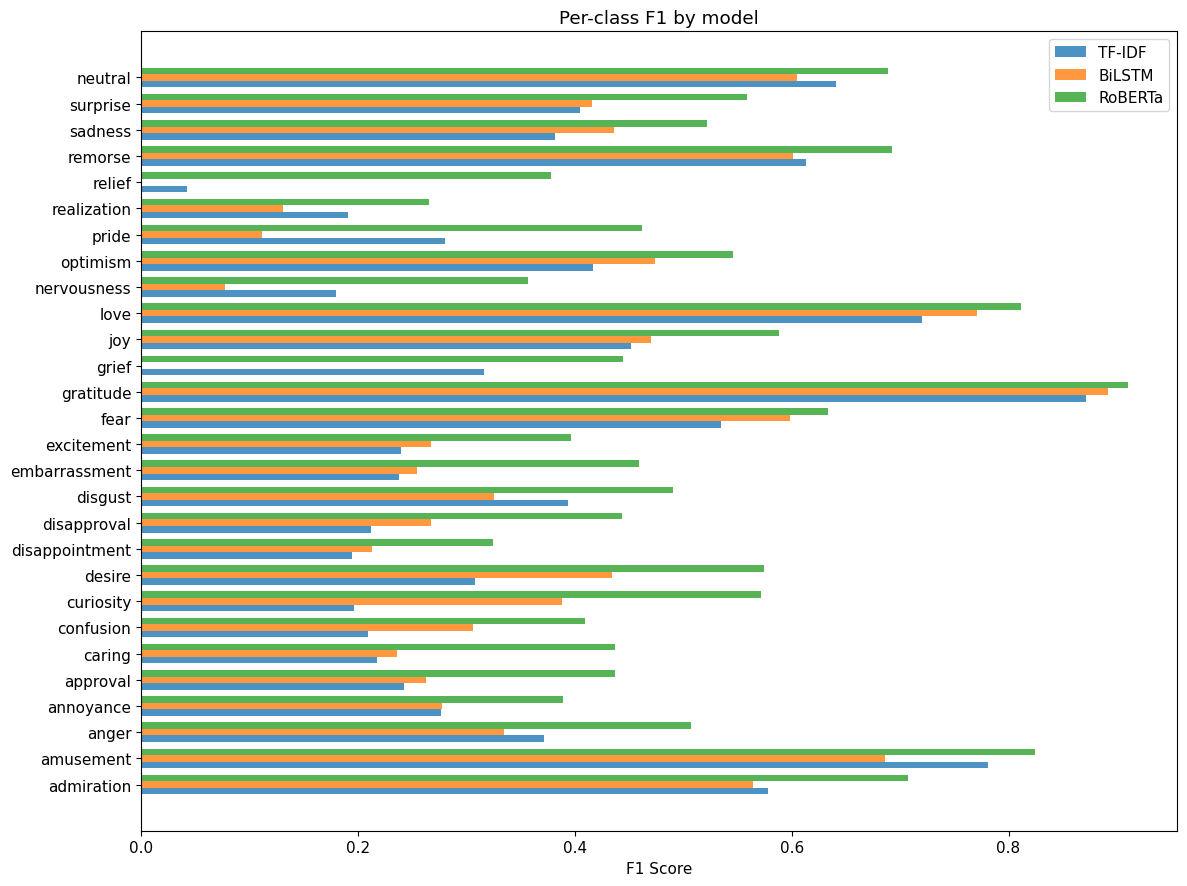

In [32]:
# per-class F1 for all models
f1_tfidf_per = f1_score(y_test, y_pred_tfidf, average=None, zero_division=0)
f1_lstm_per = f1_score(y_test, y_pred_lstm, average=None, zero_division=0)
f1_roberta_per = f1_score(y_test, y_pred_roberta, average=None, zero_division=0)

fig, ax = plt.subplots(figsize=(12, 9))
y_pos = np.arange(len(emotions))
width = 0.25

ax.barh(y_pos - width, f1_tfidf_per, width, label='TF-IDF', alpha=0.8)
ax.barh(y_pos, f1_lstm_per, width, label='BiLSTM', alpha=0.8)
ax.barh(y_pos + width, f1_roberta_per, width, label='RoBERTa', alpha=0.8)

ax.set_yticks(y_pos)
ax.set_yticklabels(emotions)
ax.set_xlabel('F1 Score')
ax.set_title('Per-class F1 by model')
ax.legend()
plt.tight_layout()
plt.show()

Gratitude and amusement are easy across the board. The rare emotions tell a more interesting story: grief (0.44), relief (0.38), and pride (0.46) all do okay with RoBERTa despite tiny training sets. The hardest for RoBERTa are realization (0.27), disappointment (0.33), and nervousness (0.36), where the emotion is subtle even with enough context.

In [33]:
# top 5 and bottom 5 for RoBERTa
sorted_f1 = sorted(zip(emotions, f1_roberta_per), key=lambda x: x[1], reverse=True)

print('Easiest emotions (RoBERTa F1):')
for name, score in sorted_f1[:5]:
    print(f'  {name}: {score:.3f}')

print('\nHardest emotions:')
for name, score in sorted_f1[-5:]:
    print(f'  {name}: {score:.3f}')

Easiest emotions (RoBERTa F1):
  gratitude: 0.910
  amusement: 0.824
  love: 0.811
  admiration: 0.707
  remorse: 0.693

Hardest emotions:
  annoyance: 0.389
  relief: 0.378
  nervousness: 0.357
  disappointment: 0.325
  realization: 0.265


In [34]:
# misclassified examples from RoBERTa
print('Misclassified examples (RoBERTa):\n')
count = 0
for i in range(len(test_df)):
    true = set(e for j, e in enumerate(emotions) if y_test[i, j] == 1)
    pred = set(e for j, e in enumerate(emotions) if y_pred_roberta[i, j] == 1)
    if true != pred and len(true) > 0 and len(pred) > 0:
        print(f"Text: '{test_df.iloc[i]['text'][:120]}'")
        print(f'  True: {true}')
        print(f'  Pred: {pred}')
        print()
        count += 1
        if count >= 10:
            break

Misclassified examples (RoBERTa):

Text: 'I’m really sorry about your situation :( Although I love the names Sapphira, Cirilla, and Scarlett!'
  True: {'sadness'}
  Pred: {'sadness', 'remorse', 'love'}

Text: 'It's wonderful because it's awful. At not with.'
  True: {'admiration'}
  Pred: {'disgust', 'admiration'}

Text: 'Kings fan here, good luck to you guys! Will be an interesting game to watch! '
  True: {'excitement'}
  Pred: {'optimism'}

Text: '100%! Congrats on your job too!'
  True: {'gratitude'}
  Pred: {'admiration', 'gratitude'}

Text: 'I’m sorry to hear that friend :(. It’s for the best most likely if she didn’t accept you for who you are'
  True: {'remorse'}
  Pred: {'sadness', 'remorse'}

Text: 'Girlfriend weak as well, that jump was pathetic.'
  True: {'sadness'}
  Pred: {'sadness', 'disappointment'}

Text: '[NAME] has towed the line of the Dark Side. He wouldn't cross it by doing something like this.'
  True: {'annoyance', 'disapproval'}
  Pred: {'neutral'}

Text: 'I ne

Anger/annoyance is the biggest confusion pair, which makes sense since they're the same emotion at different intensities. Joy's top confusion is actually admiration (14 cases), not amusement. The biggest pattern though is neutral as a catch-all: annoyance→neutral (93), approval→neutral (86), realization→neutral (63). When the model isn't confident, it defaults to neutral.

In [35]:
# when RoBERTa misses an emotion, what does it predict instead?
print('When RoBERTa gets it wrong, what does it predict instead?\n')
for j, emo in enumerate(emotions):
    missed = (y_test[:, j] == 1) & (y_pred_roberta[:, j] == 0)
    if missed.sum() == 0:
        continue
    false_preds = y_pred_roberta[missed].sum(axis=0)
    if false_preds.sum() == 0:
        continue
    top_confused = sorted(zip(emotions, false_preds), key=lambda x: x[1], reverse=True)[:3]
    top_str = ', '.join(f'{name}({int(c)})' for name, c in top_confused if c > 0)
    if top_str:
        print(f'  {emo} -> {top_str}')

When RoBERTa gets it wrong, what does it predict instead?

  admiration -> neutral(30), love(28), approval(16)
  amusement -> neutral(9), admiration(4), annoyance(3)
  anger -> neutral(38), annoyance(28), disapproval(11)
  annoyance -> neutral(93), disapproval(27), curiosity(16)
  approval -> neutral(86), admiration(32), caring(16)
  caring -> neutral(24), approval(9), admiration(7)
  confusion -> neutral(42), curiosity(36), admiration(5)
  curiosity -> neutral(26), confusion(11), annoyance(9)
  desire -> optimism(11), neutral(10), annoyance(4)
  disappointment -> neutral(45), annoyance(23), disapproval(13)
  disapproval -> neutral(70), annoyance(22), approval(13)
  disgust -> annoyance(20), anger(12), neutral(12)
  embarrassment -> annoyance(7), neutral(6), disgust(5)
  excitement -> neutral(17), admiration(11), joy(10)
  fear -> neutral(5), sadness(4), caring(3)
  gratitude -> admiration(11), joy(11), excitement(7)
  grief -> curiosity(1), sadness(1), neutral(1)
  joy -> admiration(1

The top confusion pairs are anger↔annoyance, approval↔admiration, and confusion↔curiosity. But the real story is neutral absorbing everything: it's the default prediction when confidence is low, which inflates neutral's recall at the expense of subtler emotions.

Correlation between training samples and RoBERTa F1: 0.341


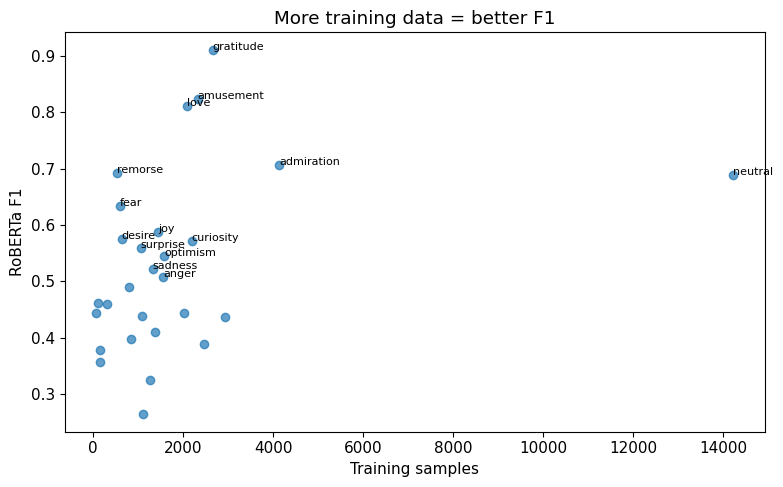

In [36]:
# how much does training set size matter?
train_counts = train_df[emotions].sum().values
correlation = np.corrcoef(train_counts, f1_roberta_per)[0, 1]
print(f'Correlation between training samples and RoBERTa F1: {correlation:.3f}')

plt.figure(figsize=(8, 5))
plt.scatter(train_counts, f1_roberta_per, alpha=0.7)
for i, emo in enumerate(emotions):
    if f1_roberta_per[i] > 0.5 or f1_roberta_per[i] < 0.1 or train_counts[i] > 10000:
        plt.annotate(emo, (train_counts[i], f1_roberta_per[i]), fontsize=8)
plt.xlabel('Training samples')
plt.ylabel('RoBERTa F1')
plt.title('More training data = better F1')
plt.tight_layout()
plt.show()

Correlation of 0.34, moderate but not overwhelming. Some rare emotions like grief and relief actually do fine with RoBERTa despite having very few training samples. It's not purely about data quantity: ambiguous emotions like realization and disappointment are hard regardless of sample size.